In [38]:
#Import Modules 
import os 
import csv 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import numpy as np
import requests
from citipy import citipy
import json
from scipy.stats import ttest_ind

In [2]:
#Open Wine File 
csv_path = 'Resources/winemag-data.csv'

In [3]:
#Read wine data 
wine_data_pd = pd.read_csv(csv_path)

#Cleaning Data 
clean_data_pd = wine_data_pd.drop(['taster_name', 'taster_twitter_handle'], axis=1)
clean_data_pd = clean_data_pd.dropna(subset=['price', 'region_1','designation','points','price','title','description','variety'])
clean_data_pd.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
#Drop all columns with NaN to find most exact locaton for region_2
us_data = clean_data_pd.dropna()
#us_data = us_data[us_data['country']=='US']

#Showing overview of data
us_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
33,33,US,"Rustic and dry, this has flavors of berries, c...",Puma Springs Vineyard,86,50.0,California,Dry Creek Valley,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Red Blend,Envolve


In [5]:
#Finding the average score for each winery 
grouped_wine = us_data.groupby('winery')

#Finding the the province of each winery
province_wine = pd.DataFrame(grouped_wine['region_2'].unique())

#Finding the which wine comes from each country 
country_wine = pd.DataFrame(grouped_wine['country'].unique())

#Finding the average of the price 
mean_wine = pd.DataFrame(grouped_wine['price'].mean())

#Merging the dataframes
wine_pd = pd.merge(province_wine, country_wine, on = 'winery')

#Merging the tables together 
wine_pd = pd.merge(wine_pd, mean_wine, on = 'winery')

#Resetting the Index
wine_pd = wine_pd.reset_index()

#Setting Province as a string 
wine_pd['region_2'] = wine_pd['region_2'].str[0]

#Setting Country as a string 
wine_pd['country'] = wine_pd['country'].str[0]

In [6]:
#Displaying the Data Frame 
wine_pd.head()

,winery,region_2,country,price
0,10 Knots,Central Coast,US,28.000000
1,100 Percent Wine,California Other,US,18.000000
2,1000 Stories,California Other,US,19.000000
3,12C Wines,Napa,US,92.600000
4,14 Hands,Columbia Valley,US,20.897436


In [7]:
#Finding the wrost 200 wineries amongst the dataset
worst_us_wineries = wine_pd.nsmallest(200, 'price', keep = 'last')

#Displaying the 200 wrost wineries 
worst_us_wineries.count()

winery      200
region_2    200
country     200
price       200
dtype: int64

In [8]:
#Finding the best 200 wineries amongst the dataset 
best_us_wineries = wine_pd.nlargest(200, 'price', keep = 'last')

#Displaying the 50 wrost wineries 
best_us_wineries.head()

,winery,region_2,country,price
3655,Yao Ming,Napa,US,625.000000
3440,Verité,Sonoma,US,373.333333
1737,Kapcsandy Family Winery,Napa,US,325.000000
1577,Hundred Acre,Napa,US,300.000000
164,Araujo,Napa,US,275.000000


In [69]:
#Setting region_2 to a new variable 
region_2 = best_us_wineries['region_2']

#Setting country to a new variable 
country = best_us_wineries['country']

#Zipping together region_2 and country 
location = zip(region_2, country)

#Setting lat, lng, and city_list a list
lat = []
lng = []
city_list = []

#Api_key
api_key = 'd44516f8f6db4dab8c39e341cbdd2719' 

In [10]:
# #Making a for loop to find the the latitude and longitude of each city in which the winery is located 
# for location in location: 
#     url = (f'https://api.opencagedata.com/geocode/v1/json?q={location[0]}%2C%20{location[1]}&key={api_key}')
#     response = requests.get(url)
#     cordinate_data = response.json()
#     print(cordinate_data)
#     #Appending the lat and long to their list 
#     lat.append(cordinate_data['results'][0]['geometry']['lat'])
#     lng.append(cordinate_data['results'][0]['geometry']['lng'])

In [11]:
# #Adding Latitude and Longitude to the DataFrame 
# best_us_wineries['Latitude']=lat
# best_us_wineries['Longitude']=lng

# #Zipping the cordinates together
# cordinates = zip(lat,lng)

# #Displaying the best_wineries DataFrame
# best_us_wineries.head()

In [12]:
#Setting city_list as a list 
# city_list = []

# #Finding the city for the corresponding cordinates 
# for cordinates in cordinates: 
#     city = citipy.nearest_city(cordinates[0], cordinates[1]).city_name
#     city_list.append(city)

# #Finding the length of the list of cities 
# len(city_list)

In [13]:
#Adding City to the best_us_wineries 
# best_us_wineries['City'] = city_list

In [14]:
#Setting temp and hum and a list 
# temp = []
# hum = []

# #Weather api key #Remember to put into another file 
# weather_api_key = 'e7909cb56283b125242b31247d3922d8'

# #Url of open weather map
# url =  'http://api.openweathermap.org/data/2.5/weather?'

# #Setting city to its own DataFrame 
# city = best_us_wineries['City']

# #Finding the temperature for the corresponding city 
# for city in city:
#     query_url = url + 'appid=' + weather_api_key + '&q=' + city + '&units=imperial'
#     weather_response = requests.get(query_url)
#     weather_data = weather_response.json()
    
#     temp.append(weather_data['main']['temp_max'])

In [15]:
#Adding temperature to the best_us_wineries 
# best_us_wineries['Temperature'] = temp

# #Displaying the DataFrame 
# best_us_wineries.head()

In [16]:
#Setting best_temp and best_price as a new variable 
# best_temp = best_us_wineries['Temperature']
# best_price = best_us_wineries['price']

In [17]:
csv_path = 'Resources/best_200_wineries.csv'
best_us_wineries = pd.read_csv(csv_path)
best_us_wineries

,Unnamed: 0,winery,region_2,country,price,Latitude,Longitude,City,Temperature
0,3655,Yao Ming,Napa,US,625.000000,39.356583,-120.182158,napa,87.01
1,3440,Verité,Sonoma,US,373.333333,39.356583,-120.182158,windsor,53.60
2,1737,Kapcsandy Family Winery,Napa,US,325.000000,39.356583,-120.182158,napa,87.01
3,1577,Hundred Acre,Napa,US,300.000000,39.356583,-120.182158,napa,87.01
4,164,Araujo,Napa,US,275.000000,39.356583,-120.182158,napa,87.01
...,...,...,...,...,...,...,...,...,...
195,1020,Double Eagle,Napa,US,80.000000,39.356583,-120.182158,napa,87.01
196,1007,Domaine de la Cote,Central Coast,US,80.000000,45.344287,-122.667037,cessnock,71.01
197,957,Den Hoed,Columbia Valley,US,80.000000,41.665744,-70.141765,columbia,66.20
198,792,Constant,Sonoma,US,80.000000,38.000000,-121.400000,windsor,53.60


In [30]:
best_temp = best_us_wineries['Temperature']
best_price = best_us_wineries['price']

In [31]:
# region_2 = worst_us_wineries['region_2']
# country = worst_us_wineries['country']

# location = zip(region_2, country)

# lat = []
# lng = []
# fips = []
# city_list = []

# api_key = 'd44516f8f6db4dab8c39e341cbdd2719' 

In [19]:
# for location in location: 
#     url = (f'https://api.opencagedata.com/geocode/v1/json?q={location[0]}%2C%20{location[1]}&key={api_key}')
#     response = requests.get(url)
#     cordinate_data = response.json()
#     lat.append(cordinate_data['results'][0]['geometry']['lat'])
#     lng.append(cordinate_data['results'][0]['geometry']['lng'])

In [21]:
# lat = worst_us_wineries['Latitude']
# lng = worst_us_wineries['Longitude']

# cordinates = zip(lat,lng)

In [22]:
# city_list = []

# for cordinates in cordinates: 
#     city = citipy.nearest_city(cordinates[0], cordinates[1]).city_name
#     city_list.append(city)

# #Finding the length of the list of cities 
# len(city_list)

200

In [23]:
# worst_us_wineries['City']= city_list

,Unnamed: 0,winery,region_2,country,price,Latitude,Longitude,City
0,2415,Pam's Cuties,California Other,US,4.0,39.356583,-120.182158,truckee
1,2040,Mancan,California Other,US,5.0,39.356583,-120.182158,truckee
2,1068,Earth's Harvest,California Other,US,5.0,39.356583,-120.182158,truckee
3,1260,Fox Brook,California Other,US,6.0,39.356583,-120.182158,truckee
4,3694,flipflop,California Other,US,7.0,39.356583,-120.182158,truckee


In [24]:
# temp = []
# hum = []

# weather_api_key = 'e7909cb56283b125242b31247d3922d8'

# city = worst_us_wineries['City']

# url =  'http://api.openweathermap.org/data/2.5/weather?'

# for city in city:
#     query_url = url + 'appid=' + weather_api_key + '&q=' + city + '&units=imperial'
#     weather_response = requests.get(query_url)
#     weather_data = weather_response.json()
    
#     temp.append(weather_data['main']['temp_max'])

In [25]:
# worst_us_wineries['Temperature'] = temp

In [43]:
# worst_us_wineries.drop(['Unnamed: 0'],axis=1)
# worst_us_wineries.to_csv('200_worst_wineries.csv')

In [71]:
csv_path = 'Resources/200_worst_wineries.csv'
worst_us_wineries = pd.read_csv(csv_path)
worst_us_wineries

FileNotFoundError: [Errno 2] File Resources/200_worst_wineries.csv does not exist: 'Resources/200_worst_wineries.csv'

In [59]:
temp = worst_us_wineries['Temperature']
price = worst_us_wineries['price']

In [60]:
us_wineries_pd = pd.merge(worst_us_wineries, best_us_wineries, on = ['winery','region_2'\
,'country','price','Latitude','Longitude','City','Temperature'], how = 'outer')


In [61]:
us_temp = us_wineries_pd['Temperature']
us_price = us_wineries_pd['price']

(slope, intercept,  rvalue, pvalue, stderr) = sts.linregress(us_temp, us_price)
lin_reg = ('y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2)))
lin_reg


'y = 2.24x + -103.69'

The r squared value is: 0.15164039280952818


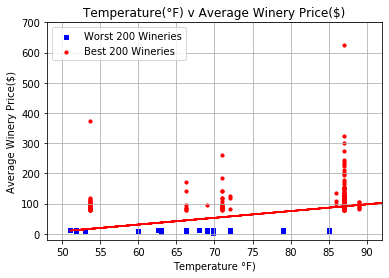

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(temp, price, s=10, c='b', marker="s", label='Worst 200 Wineries')
ax1.scatter(best_temp,best_price, s=10, c='r', marker="o", label='Best 200 Wineries')
plt.legend(loc='upper left')

plt.xlim(48,92)
plt.ylim(-20,700)

#Giving names to labels
plt.title('Temperature(°F) v Average Winery Price($)')
plt.xlabel('Temperature °F)')
plt.ylabel('Average Winery Price($)')

x_values = us_temp
regress_values = x_values * slope + intercept 
plt.plot(x_values, regress_values, 'r-')
plt.grid()
print(f'The r squared value is: {rvalue**2}')
plt.show()

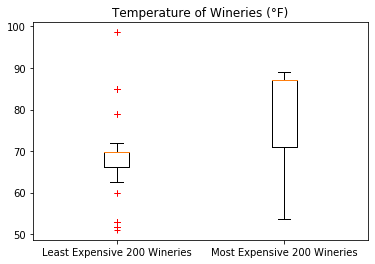

In [63]:
data = [temp, best_temp]

#Plotting the box and whisker plot 
fig, ax = plt.subplots()
ax.set_title('Temperature of Wineries (°F)')
ax.boxplot(data, sym = 'r+')
plt.xticks([1, 2], ['Least Expensive 200 Wineries','Most Expensive 200 Wineries'])
plt.show()

In [64]:
temp_mean = temp.mean()

In [65]:
best_temp_mean = best_temp.mean()

In [66]:
mean_sum = {'Mean Temperature(°F) Best 200 Wineries' : [best_temp_mean],
           'Mean Temperature(°F) Worst 200 Wineries' : [temp_mean]}

In [67]:
mean_sum_pd = pd.DataFrame(mean_sum)
mean_sum_pd

,Mean Temperature(°F) Best 200 Wineries,Mean Temperature(°F) Worst 200 Wineries
0,79.901,69.9064


In [68]:
ttest_ind(best_temp, temp)

Ttest_indResult(statistic=9.58889121675457, pvalue=9.94354677351303e-20)